# Join ERP data

This notebook downloads ERP data from google sheets (`df2gspread`) and figures out the timings of the plantings and harvest.

1. Download HARVEST and PLANT from gsheets
1. Join HARVEST and PLANT based on tray and timestamps to create lifetimes


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from df2gspread import gspread2df as g2d
import seaborn as sns

pd.set_option('display.max_rows', 10)

%matplotlib inline

# Load up ERP data sources
From [this](https://docs.google.com/spreadsheets/d/1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE/edit#gid=1027781493) google sheet.

In [2]:
import re

def erp_rack_parser(s):
    resp = {'RACK': None, 'RACK_EXCEPTION': ''}
    try:
        resp['RACK'] = int(re.findall(r'Rack (\d+)', s)[0])
    except Exception as e:
        resp['RACK_EXCEPTION'] = str(e)
    return pd.Series(resp)

def erp_tray_parser(s):
    resp = {'TRAY': None, 'TRAY_EXCEPTION': ''}
    try:
        resp['TRAY'] = int(re.findall(r'Tray (\d+)', s)[0])
    except Exception as e:
        resp['TRAY_EXCEPTION'] = str(e)
    return pd.Series(resp)

## `PLANT` $\rightarrow$ `df_plant`

In [3]:
df_plant_raw = g2d.download('1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE', wks_name='PLANT', col_names=True)
df_plant_raw

,Date,Plant type,Tray ID,Rack,Level,Position,Seeded (date),Filling rate,Other comments,ID,Last Harvest
0,15.05.2018,Thai basil,Tray 133,Rack 1,Level 1 (bottom),Right,,,,Tray 13343235,08.11.2018
1,15.05.2018,Thai basil,Tray 030,Rack 1,Level 1 (bottom),Center,,,,Tray 03043235,07.11.2018
2,15.05.2018,Thai basil,Tray 141,Rack 1,Level 1 (bottom),Left,,,,Tray 14143235,
3,15.05.2018,Thai basil,Tray 137,Rack 1,Level 2,Center,,,,Tray 13743235,26.10.2018
4,15.05.2018,Thai basil,Tray 134,Rack 1,Level 2,Right,,,,Tray 13443235,07.11.2018
...,...,...,...,...,...,...,...,...,...,...,...
292,,,,,,,,,,,#N/A
293,,,,,,,,,,,#N/A
294,,,,,,,,,,,#N/A
295,,,,,,,,,,,#N/A


In [4]:
# cleanse the ERP data
df_plant = df_plant_raw[df_plant_raw.Rack.notnull() & (~df_plant_raw.Rack.isin(['','NA','#N/A',]))].copy()
df_plant['DATE_PLANTED'] = pd.core.tools.datetimes.to_datetime(df_plant.Date)
df_plant['DATE_SEEDED'] = pd.core.tools.datetimes.to_datetime(df_plant['Seeded (date)'], errors='ignore')
df_plant[['TRAY', 'TRAY_EXCEPTION']] = df_plant['Tray ID'].apply(erp_tray_parser)
df_plant[['RACK', 'RACK_EXCEPTION']] = df_plant['Rack'].apply(erp_rack_parser)
df_plant['PLANT_PLANTED'] = df_plant['Plant type']
df_plant = df_plant.rename(columns={"Rack": "Rack (raw)"})
df_plant

,Date,Plant type,Tray ID,Rack (raw),Level,Position,Seeded (date),Filling rate,Other comments,ID,Last Harvest,DATE_PLANTED,DATE_SEEDED,TRAY,TRAY_EXCEPTION,RACK,RACK_EXCEPTION,PLANT_PLANTED
0,15.05.2018,Thai basil,Tray 133,Rack 1,Level 1 (bottom),Right,,,,Tray 13343235,08.11.2018,2018-05-15,NaT,133.0,,1,,Thai basil
1,15.05.2018,Thai basil,Tray 030,Rack 1,Level 1 (bottom),Center,,,,Tray 03043235,07.11.2018,2018-05-15,NaT,30.0,,1,,Thai basil
2,15.05.2018,Thai basil,Tray 141,Rack 1,Level 1 (bottom),Left,,,,Tray 14143235,,2018-05-15,NaT,141.0,,1,,Thai basil
3,15.05.2018,Thai basil,Tray 137,Rack 1,Level 2,Center,,,,Tray 13743235,26.10.2018,2018-05-15,NaT,137.0,,1,,Thai basil
4,15.05.2018,Thai basil,Tray 134,Rack 1,Level 2,Right,,,,Tray 13443235,07.11.2018,2018-05-15,NaT,134.0,,1,,Thai basil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,05.11.2018,Coriander,Tray 059,Rack 4,Level 5 (top),Center,23.10.2018,,,Tray 05943409,,2018-05-11,2018-10-23,59.0,,4,,Coriander
287,05.11.2018,Coriander,Tray 056,Rack 4,Level 5 (top),Center,23.10.2018,,,Tray 05643409,,2018-05-11,2018-10-23,56.0,,4,,Coriander
288,05.11.2018,Coriander,Tray 067,Rack 4,Level 5 (top),Right,23.10.2018,,,Tray 06743409,,2018-05-11,2018-10-23,67.0,,4,,Coriander
289,05.11.2018,Coriander,Tray 071,Rack 4,Level 5 (top),Right,23.10.2018,,,Tray 07143409,,2018-05-11,2018-10-23,71.0,,4,,Coriander


In [5]:
print(df_plant.RACK.value_counts(dropna=False))
print(df_plant.TRAY.value_counts(dropna=False))

assert df_plant.Date.isnull().sum() == 0

2    87
1    78
5    65
4    61
Name: RACK, dtype: int64
90.0     6
47.0     6
57.0     5
133.0    4
139.0    4
        ..
48.0     1
12.0     1
61.0     1
107.0    1
148.0    1
Name: TRAY, Length: 134, dtype: int64


# `HARVEST` $\rightarrow$ `df_harvest`

In [6]:
df_harvest_raw = g2d.download('1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE', wks_name='HARVEST', col_names=True)
df_harvest_raw

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),2nd Harvest (Y/N),Comment
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,,
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,,
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,,
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,,
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,,
...,...,...,...,...,...,...,...
526,08.11.2018,Tunco,Coriander,Tray 133,230,Y,Dried during production
527,08.11.2018,Tunco,Coriander,Tray 159,43,Y,Dried during production
528,08.11.2018,Tunco,Coriander,Tray 096,416,N,
529,08.11.2018,Tunco,Coriander,Tray 020,510,N,


In [7]:
df_harvest = df_harvest_raw[df_harvest_raw['Tray ID'].notnull() & (~df_harvest_raw['Tray ID'].isin(['','NA','#N/A',]))].copy()
df_harvest['DATE_HARVESTED'] = pd.core.tools.datetimes.to_datetime(df_harvest['Tidsmerke'], errors='coerce')
df_harvest[['TRAY', 'TRAY_EXCEPTION']] = df_harvest['Tray ID'].apply(erp_tray_parser)
df_harvest['PLANT_HARVESTED'] = df_harvest['Product']
df_harvest

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),2nd Harvest (Y/N),Comment,DATE_HARVESTED,TRAY,TRAY_EXCEPTION,PLANT_HARVESTED
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,,,2018-03-28,1,,Mint ’maroccan’ LBH
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,,,2018-03-28,2,,Mint ’maroccan’ LBH
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,,,2018-06-04,3,,Mint ’maroccan’ Kristiansand
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,,,2018-07-04,4,,Basilikum Genovese 'Storbladet'
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,,,2018-07-04,5,,Basilikum Genovese 'Storbladet'
...,...,...,...,...,...,...,...,...,...,...,...
526,08.11.2018,Tunco,Coriander,Tray 133,230,Y,Dried during production,2018-08-11,133,,Coriander
527,08.11.2018,Tunco,Coriander,Tray 159,43,Y,Dried during production,2018-08-11,159,,Coriander
528,08.11.2018,Tunco,Coriander,Tray 096,416,N,,2018-08-11,96,,Coriander
529,08.11.2018,Tunco,Coriander,Tray 020,510,N,,2018-08-11,20,,Coriander


In [8]:
df_harvest

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),2nd Harvest (Y/N),Comment,DATE_HARVESTED,TRAY,TRAY_EXCEPTION,PLANT_HARVESTED
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,,,2018-03-28,1,,Mint ’maroccan’ LBH
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,,,2018-03-28,2,,Mint ’maroccan’ LBH
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,,,2018-06-04,3,,Mint ’maroccan’ Kristiansand
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,,,2018-07-04,4,,Basilikum Genovese 'Storbladet'
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,,,2018-07-04,5,,Basilikum Genovese 'Storbladet'
...,...,...,...,...,...,...,...,...,...,...,...
526,08.11.2018,Tunco,Coriander,Tray 133,230,Y,Dried during production,2018-08-11,133,,Coriander
527,08.11.2018,Tunco,Coriander,Tray 159,43,Y,Dried during production,2018-08-11,159,,Coriander
528,08.11.2018,Tunco,Coriander,Tray 096,416,N,,2018-08-11,96,,Coriander
529,08.11.2018,Tunco,Coriander,Tray 020,510,N,,2018-08-11,20,,Coriander


In [9]:
print(df_harvest.TRAY_EXCEPTION.value_counts())
print(df_harvest.DATE_HARVESTED.isnull().value_counts())

    520
Name: TRAY_EXCEPTION, dtype: int64
False    518
True       2
Name: DATE_HARVESTED, dtype: int64


# Join out datasets
Spark is used to be able to do the timestamp join in SQL, this is a bit clumsy to try in pandas.

In [10]:
# reach for spark here to do some sql joins
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as sqlfun
from pyspark.sql import types as sqxt
spark = SparkSession.builder\
    .master('local[4]')\
    .appName('vfa-01-01')\
    .getOrCreate()
spark

In [11]:
ddf_harvest = spark.createDataFrame(df_harvest)
ddf_harvest.registerTempTable("HARVEST")
ddf_plant = spark.createDataFrame(df_plant)
ddf_plant.registerTempTable("PLANT")

In [12]:
# Check the number of racks that a tray has appeared in...

spark.sql("""
select TRAY, count(distinct RACK) as NRACKS_PER_TRAY
from PLANT
group by TRAY
""").toPandas().set_index("TRAY").NRACKS_PER_TRAY.value_counts()

1    62
2    58
3    13
4     1
Name: NRACKS_PER_TRAY, dtype: int64

In [13]:
# roll up harvests on the same day

ddf_harvest_total = spark.sql("""
select
    DATE_HARVESTED,
    TRAY,
    PLANT_HARVESTED,
    sum(cast(`Weight of harvest (g)` as float)) as TOTAL_WEIGHT
from HARVEST
group by
    DATE_HARVESTED,
    TRAY,
    PLANT_HARVESTED
""")
ddf_harvest_total.registerTempTable("HARVEST_TOTAL")
ddf_harvest_total.show(10)
ddf_harvest.count()

+-------------------+----+----------------+------------+
|     DATE_HARVESTED|TRAY| PLANT_HARVESTED|TOTAL_WEIGHT|
+-------------------+----+----------------+------------+
|2018-04-07 00:00:00| 116|            Mint|        30.0|
|2018-11-04 00:00:00|  22|    Leaf parsley|        44.0|
|2018-05-24 00:00:00|  58|Coriander Marino|       719.0|
|2018-09-27 00:00:00|  14|    Leaf parsley|       624.0|
|2018-10-25 00:00:00|  31|       Coriander|       769.0|
|2018-06-28 00:00:00|  19|            Mint|       242.0|
|2018-03-07 00:00:00| 141|      Thai basil|      1482.0|
|2018-10-25 00:00:00|  41|      Thai basil|       564.0|
|2018-06-28 00:00:00|  93|       Coriander|       273.0|
|2018-08-16 00:00:00|  31|            Mint|       250.0|
+-------------------+----+----------------+------------+
only showing top 10 rows



520

In [14]:
# Group and index harvests after a planting date

ddf_lifetime = spark.sql("""
select
    P.DATE_PLANTED,
    H.DATE_HARVESTED,
    H.TRAY,
    P.RACK,
    datediff(H.DATE_HARVESTED, P.DATE_PLANTED) as DAYS_GROWTH,
    H.TOTAL_WEIGHT,
    row_number() over (
        partition by P.DATE_PLANTED, P.TRAY, P.RACK
        order by datediff(H.DATE_HARVESTED, P.DATE_PLANTED) asc
    ) as HARVEST_IDX,
    P.PLANT_PLANTED,
    H.PLANT_HARVESTED
from HARVEST_TOTAL as H
inner join PLANT as P on 
    H.DATE_HARVESTED > P.DATE_PLANTED and
    H.TRAY = P.TRAY
""")

ddf_lifetime.registerTempTable("LIFETIME")
ddf_lifetime, ddf_lifetime.count()

(DataFrame[DATE_PLANTED: timestamp, DATE_HARVESTED: timestamp, TRAY: bigint, RACK: bigint, DAYS_GROWTH: int, TOTAL_WEIGHT: double, HARVEST_IDX: int, PLANT_PLANTED: string, PLANT_HARVESTED: string],
 425)

In [15]:
ddf_lifetime.orderBy("TRAY", "DATE_PLANTED", "HARVEST_IDX").show(60)

+-------------------+-------------------+----+----+-----------+------------+-----------+-------------+--------------------+
|       DATE_PLANTED|     DATE_HARVESTED|TRAY|RACK|DAYS_GROWTH|TOTAL_WEIGHT|HARVEST_IDX|PLANT_PLANTED|     PLANT_HARVESTED|
+-------------------+-------------------+----+----+-----------+------------+-----------+-------------+--------------------+
|2018-02-11 00:00:00|2018-03-28 00:00:00|   2|   4|         45|       521.0|          1|     Salanova| Mint ’maroccan’ LBH|
|2018-02-11 00:00:00|2018-06-28 00:00:00|   2|   4|        137|       288.0|          2|     Salanova|                Mint|
|2018-01-10 00:00:00|2018-01-11 00:00:00|   3|   5|          1|       470.0|          1|    Coriander|           Coriander|
|2018-01-10 00:00:00|2018-06-04 00:00:00|   3|   5|        145|       528.0|          2|    Coriander|Mint ’maroccan’ K...|
|2018-01-10 00:00:00|2018-09-27 00:00:00|   3|   5|        260|       580.0|          3|    Coriander|           Coriander|
|2018-01

In [16]:
# build a dummy table to get the next plant date for each rack, tray and plant date
ddf_next_plant_dates = spark.sql("""
select TRAY, RACK, DATE_PLANTED,
    lead(DATE_PLANTED, 1, current_date()) over (partition by TRAY, RACK order by DATE_PLANTED asc)
    as NEXT_DATE_PLANTED
from (
    select TRAY, RACK, DATE_PLANTED
    from PLANT
    group by TRAY, RACK, DATE_PLANTED
) X
""")
ddf_next_plant_dates.registerTempTable("NEXT_PLANTINGS")
ddf_next_plant_dates, ddf_next_plant_dates.count()

(DataFrame[TRAY: double, RACK: bigint, DATE_PLANTED: timestamp, NEXT_DATE_PLANTED: timestamp],
 290)

In [17]:

# join dummy table to ensure that we restrict harvests to between plantings
ddf_corrected_lifetimes = spark.sql("""
select
    L.*,
    P.NEXT_DATE_PLANTED
from LIFETIME as L
inner join NEXT_PLANTINGS as P on
    L.RACK=P.RACK and
    L.TRAY=P.TRAY and
    L.DATE_PLANTED=P.DATE_PLANTED and
    L.DATE_HARVESTED < P.NEXT_DATE_PLANTED
order by RACK, TRAY, DATE_PLANTED, HARVEST_IDX
""")

# add in a cumulative sum between planting dates
ddf_corrected_lifetimes = ddf_corrected_lifetimes.selectExpr("*","""
    sum(TOTAL_WEIGHT) over (
        partition by DATE_PLANTED, RACK, TRAY order by DATE_HARVESTED asc rows unbounded preceding
    ) as CUM_WEIGHT
""",
"""
    sum(DAYS_GROWTH) over (
        partition by DATE_PLANTED, RACK, TRAY order by DATE_HARVESTED asc rows unbounded preceding
    ) as CUM_DAYS
""")

ddf_corrected_lifetimes = ddf_corrected_lifetimes.orderBy("RACK", "TRAY", "DATE_PLANTED", "HARVEST_IDX")
ddf_corrected_lifetimes.persist()

DataFrame[DATE_PLANTED: timestamp, DATE_HARVESTED: timestamp, TRAY: bigint, RACK: bigint, DAYS_GROWTH: int, TOTAL_WEIGHT: double, HARVEST_IDX: int, PLANT_PLANTED: string, PLANT_HARVESTED: string, NEXT_DATE_PLANTED: timestamp, CUM_WEIGHT: double, CUM_DAYS: bigint]

In [18]:
ddf_corrected_lifetimes.show(50)

+-------------------+-------------------+----+----+-----------+------------+-----------+-------------+-----------------+-------------------+----------+--------+
|       DATE_PLANTED|     DATE_HARVESTED|TRAY|RACK|DAYS_GROWTH|TOTAL_WEIGHT|HARVEST_IDX|PLANT_PLANTED|  PLANT_HARVESTED|  NEXT_DATE_PLANTED|CUM_WEIGHT|CUM_DAYS|
+-------------------+-------------------+----+----+-----------+------------+-----------+-------------+-----------------+-------------------+----------+--------+
|2018-08-21 00:00:00|2018-09-27 00:00:00|  14|   1|         37|       624.0|          1| Leaf parsley|     Leaf parsley|2018-11-08 00:00:00|     624.0|      37|
|2018-08-21 00:00:00|2018-11-04 00:00:00|  14|   1|         75|        28.0|          2| Leaf parsley|           Thymes|2018-11-08 00:00:00|     652.0|     112|
|2018-08-13 00:00:00|2018-09-20 00:00:00|  17|   1|         38|       500.0|          1|    Coriander|        Coriander|2018-11-08 00:00:00|     500.0|      38|
|2018-08-13 00:00:00|2018-11-06 00

Text(0.5, 1.0, 'DAYS_GROWTH (shortest lifetimes)')

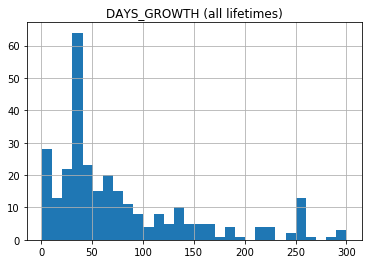

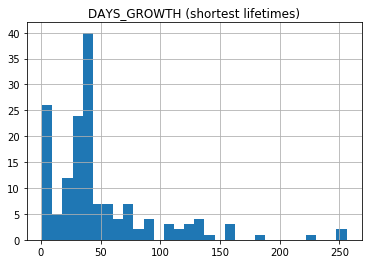

In [19]:
ddf_corrected_lifetimes.select("DAYS_GROWTH").toPandas().hist(bins=30)
plt.title("DAYS_GROWTH (all lifetimes)")

ddf_corrected_lifetimes.filter("HARVEST_IDX=1").select("DAYS_GROWTH").toPandas().hist(bins=30)
plt.title("DAYS_GROWTH (shortest lifetimes)")

In [20]:
# Create a very strict dataset for viz
# - same plant is harvested as planted
# - less than 90 days betwen
df_sample = ddf_corrected_lifetimes.toPandas()

df_sc = df_sample[(df_sample.PLANT_PLANTED == df_sample.PLANT_HARVESTED) &\
                  (df_sample.DAYS_GROWTH < 90) &\
                  (df_sample.DATE_PLANTED > '2018-07-01')]
df_sc

,DATE_PLANTED,DATE_HARVESTED,TRAY,RACK,DAYS_GROWTH,TOTAL_WEIGHT,HARVEST_IDX,PLANT_PLANTED,PLANT_HARVESTED,NEXT_DATE_PLANTED,CUM_WEIGHT,CUM_DAYS
0,2018-08-21,2018-09-27,14,1,37,624.0,1,Leaf parsley,Leaf parsley,2018-11-08,624.0,37
2,2018-08-13,2018-09-20,17,1,38,500.0,1,Coriander,Coriander,2018-11-08,500.0,38
4,2018-08-17,2018-09-20,22,1,34,380.0,1,Coriander,Coriander,2018-11-08,380.0,34
5,2018-08-17,2018-10-18,22,1,62,1394.0,2,Coriander,Coriander,2018-11-08,1774.0,96
7,2018-08-21,2018-09-10,27,1,20,60.0,1,Leaf parsley,Leaf parsley,2018-11-08,60.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...
281,2018-07-26,2018-08-16,113,5,21,347.0,1,Mint,Mint,2018-11-08,347.0,21
282,2018-07-26,2018-08-23,113,5,28,778.0,2,Mint,Mint,2018-11-08,1125.0,49
286,2018-10-09,2018-10-18,133,5,9,1646.0,1,Coriander,Coriander,2018-11-08,1646.0,9
287,2018-07-18,2018-08-17,139,5,30,330.0,1,Mint,Mint,2018-09-24,330.0,30


In [21]:
df_sc.PLANT_PLANTED.value_counts()

Coriander       60
Thai basil      22
Leaf parsley    19
Mint            13
Ruccola          2
Name: PLANT_PLANTED, dtype: int64

Coriander
Leaf parsley


/opt/conda/envs/vfa-01/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Mint
Ruccola
Thai basil


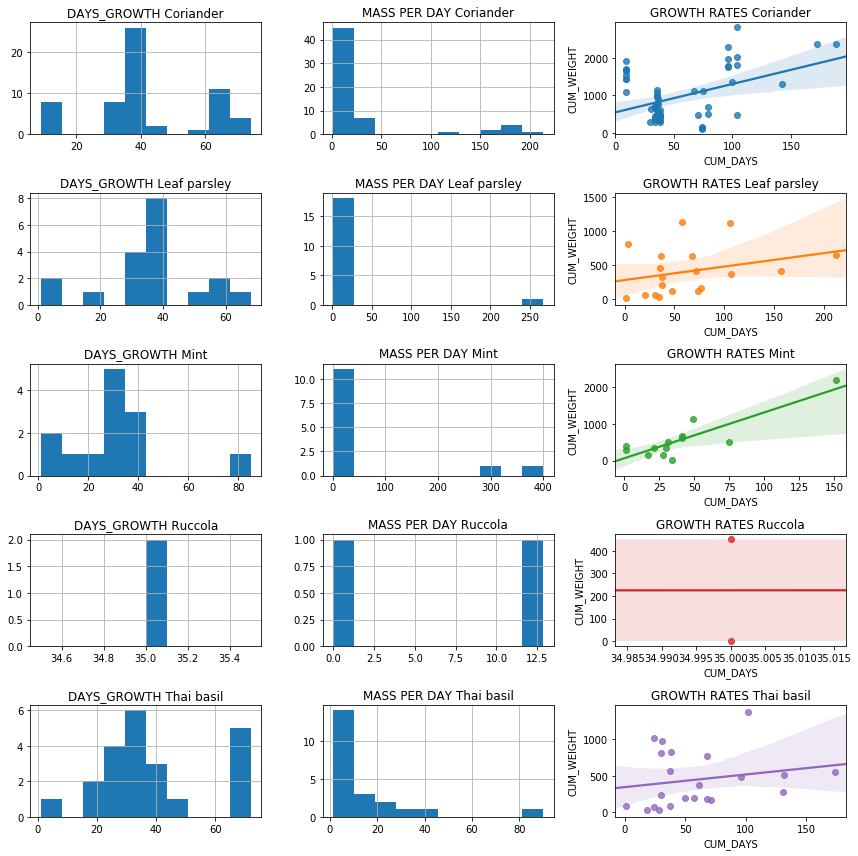

In [22]:
fig, axes = plt.subplots(nrows=len(df_sc.PLANT_PLANTED.unique()), ncols=3, figsize=(12,12))
for (plant, df), axr in zip(df_sc.groupby("PLANT_PLANTED"), axes):
    print(plant)
    df.DAYS_GROWTH.hist(ax=axr[0])
    axr[0].set_title("DAYS_GROWTH " + plant)
    
    (df.CUM_WEIGHT/df.CUM_DAYS).hist(ax=axr[1])
    axr[1].set_title("MASS PER DAY " + plant)
    
    sns.regplot(x=df.CUM_DAYS, y=df.CUM_WEIGHT, ax=axr[2])
    axr[2].set_title("GROWTH RATES " + plant)

plt.tight_layout()

# Write ERP datasets

In [23]:
import datetime
BATCH = str(datetime.datetime.today().date())
BATCH

'2018-11-08'

In [35]:
def vfa_writer(ddf, name, nparts=1):
    parquet_dir = "../data/Measurements/prepared-datasets/{NAME}_parquet/BATCH={BATCH}"\
        .format(BATCH=BATCH, NAME=name)
    json_dir = "../data/Measurements/prepared-datasets/{NAME}_json/BATCH={BATCH}"\
        .format(BATCH=BATCH, NAME=name)
    ddf_clean = ddf.selectExpr(*[
        "`%s` as %s" % (c, c.replace(" ", "_").replace("(", "").replace(")", "").upper()) \
        for c in ddf.columns \
    ]).coalesce(nparts)
    ddf_clean.write.parquet(parquet_dir, mode='overwrite')
    ddf_clean.write.json(json_dir, mode='overwrite')
    return (parquet_dir, json_dir)

In [36]:
vfa_writer(ddf_lifetime, name='lifetime')

('../data/Measurements/prepared-datasets/lifetime_parquet/BATCH=2018-11-08',
 '../data/Measurements/prepared-datasets/lifetime_json/BATCH=2018-11-08')

In [37]:
vfa_writer(ddf_corrected_lifetimes, name='lifetime_corrected')

('../data/Measurements/prepared-datasets/lifetime_corrected_parquet/BATCH=2018-11-08',
 '../data/Measurements/prepared-datasets/lifetime_corrected_json/BATCH=2018-11-08')

In [38]:
vfa_writer(ddf_plant, name='plant')

('../data/Measurements/prepared-datasets/plant_parquet/BATCH=2018-11-08',
 '../data/Measurements/prepared-datasets/plant_json/BATCH=2018-11-08')

In [39]:
vfa_writer(ddf_harvest_total, name='harvest_total')

('../data/Measurements/prepared-datasets/harvest_total_parquet/BATCH=2018-11-08',
 '../data/Measurements/prepared-datasets/harvest_total_json/BATCH=2018-11-08')

In [40]:
!date
!rclone sync ../data/Measurements/prepared-datasets vfa-Measurements:/prepared-datasets

Fri Nov  9 14:34:18 CET 2018
